## 09/05/2023

Transformer taken from:
https://keras.io/examples/timeseries/timeseries_transformer_classification/.
## TODO - implement masking from https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.ipynb 


In [17]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.backend import clear_session
from contextlib import redirect_stdout
from tensorflow.keras.callbacks import (
    CSVLogger,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
import warnings
from sklearn.preprocessing import OneHotEncoder
import time
from astronet.t2.model import T2Model_AG
import optuna
from optuna.samplers import TPESampler

In [18]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [19]:
#try with my own data 
#only using the 100GP model so that we don't have to use padding, otherwise we would use 0pt2GP.
dir = '/Users/alexgagliano/Documents/Research/HostClassifier/transformer/ZTF_Data/'
X_train = np.load(dir + 'X_train_ZTF_Obs_FullSliced_Padded_0pt2GP_hostPhotTrue_30Cut.npz')['arr_0']
X_test = np.load(dir + 'X_test_ZTF_Obs_FullSliced_Padded_0pt2GP_hostPhotTrue_30Cut.npz')['arr_0']
y_train = np.load(dir + 'y_train_ZTF_Obs_FullSliced_Padded_0pt2GP_hostPhotTrue_30Cut.npz')['arr_0']
y_test = np.load(dir + 'y_test_ZTF_Obs_FullSliced_Padded_0pt2GP_hostPhotTrue_30Cut.npz')['arr_0']

In [23]:
from collections import Counter
II Ia Ibc
Counter(y_train)

Counter({1.0: 30469, 0.0: 4663, 2.0: 1759})

In [ ]:
params = {}
#params['class_weight'] = {0:2, 1:1, 2:5} #weighting the classes
params['class_weight'] = {0:1, 1:1, 2:1} #weighting the classes

#only weighting in time 
weights = np.ones(np.shape(X_train[:, :, 0]))
weights[(X_train[:, :, 0][:, -1] < 3)] = 10
weights[(X_train[:, :, 0][:, -1] > 3) & (X_train[:, :, 0][:, -1] < 15)] = 5

weights[y_train == 0] *= params['class_weight'][0]
weights[y_train == 1] *= params['class_weight'][1]
weights[y_train == 2] *= params['class_weight'][2]

#compress -- not doing time-distributed network
weights = weights[:, 0]

In [4]:
#binarize labels 
y_train = OneHotEncoder(max_categories=3, sparse_output=False).fit_transform(y_train.reshape(-1, 1))
y_test = OneHotEncoder(max_categories=3, sparse_output=False).fit_transform(y_test.reshape(-1, 1))

params['num_classes'] = y_train.shape[1]

#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

params['batch_size'] = 128
params['epochs'] = 200
# using the optimal parameters here
params['filters']= 50
params['ff_dim'] = 32
params['embed_dim'] = 32
params['num_layers'] = 4
params['num_heads'] = 2
params['droprate'] = 0.28
# --> Number of filters to use in ConvEmbedding block, should be equal to embed_dim
params['num_filters'] = params['embed_dim']
params['passbands'] = 'XY'

ts = int(time.time())
outputfn = '0pt2GP_Transformer_wMask_FullObsTraining_OptParams'
outputdir = '/Users/alexgagliano/Documents/Research/HostClassifier/transformer/'
textPath = outputdir + '/text/'
textfile = open(textPath + "/" + outputfn + "_%s_Transformer_%s.txt"%(ts, params['passbands']), "at")

(
    _,
    timesteps,
    num_features,
) = X_train.shape 
input_shape = (params['batch_size'], timesteps, num_features)
params['input_shape'] = input_shape

model = T2Model_AG(
    input_dim=params['input_shape'],
    embed_dim=params['embed_dim'],
    num_heads=params['num_heads'],
    ff_dim=params['ff_dim'],
    num_filters=params['num_filters'],
    num_classes=params['num_classes'],
    num_layers=params['num_layers'],
    droprate=params['droprate'],
)

params['learning_rate'] = 5.e-4
opt = tf.keras.optimizers.legacy.Adam(learning_rate=params['learning_rate'])
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["acc"])
model.load_weights(outputdir+'/models/Model_0pt2GP_Transformer_wMask_FullSimTraining_OptParams_CheckpointWeights.sav')


mc = ModelCheckpoint(outputdir+'/models/Model_%s_CheckpointWeights.sav'%outputfn, monitor='val_loss', mode='min', verbose=1, save_weights_only=True, save_best_only=True, sample_weight=weights)
es = EarlyStopping(min_delta=0.001, mode="min", monitor="val_loss", patience=20, restore_best_weights=True,verbose=1)
rlrop = ReduceLROnPlateau(cooldown=5, factor=0.5, mode="min", monitor="val_loss", patience=10, verbose=1)

#write out model configuration to text file 
for key in params.keys():
    textfile.write("{} = {}\n".format(key, params[key]))
    
with redirect_stdout(textfile):
    _ = model.fit(
        X_train,
        y_train,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=(X_test, y_test),
        callbacks=[mc], verbose=2)

model.build_graph(params['input_shape'])

print(model.summary())

Model: "t2_model_ag"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_embedding_ag (ConvEmb  (None, 150, 32)           416       
 edding_AG)                                                      
                                                                 
 positional_encoding (Posit  (None, 150, 32)           0         
 ionalEncoding)                                                  
                                                                 
 transformer_block_ag (Tran  (None, 150, 32)           10656     
 sformerBlock_AG)                                                
                                                                 
 transformer_block_ag_1 (Tr  (None, 150, 32)           10656     
 ansformerBlock_AG)                                              
                                                                 
 transformer_block_ag_2 (Tr  (None, 150, 32)           

In [5]:
model.load_weights(outputdir+'/models/Model_%s_CheckpointWeights.sav'%outputfn)
loss, accuracy = model.evaluate(X_test, y_test)

378/378 [==============================] - 27s 71ms/step - loss: 0.4129 - acc: 0.8547


In [6]:
# evaluate the results as a function of phase 
y_test = y_test.argmax(axis=1)

X_test_first3 = X_test[np.nanmax(X_test[:, :, 0], axis=1) < 3, :, :]
y_test_first3 = y_test[np.nanmax(X_test[:, :, 0], axis=1) < 3]

X_test_mid15 = X_test[(np.nanmax(X_test[:, :, 0], axis=1) >3) & (np.nanmax(X_test[:, :, 0], axis=1) < 15), :, :]
y_test_mid15 = y_test[(np.nanmax(X_test[:, :, 0], axis=1) >3) & (np.nanmax(X_test[:, :, 0], axis=1) < 15)]


X_test_last15 = X_test[np.nanmax(X_test[:, :, 0], axis=1) > 15, :, :]
y_test_last15 = y_test[np.nanmax(X_test[:, :, 0], axis=1) > 15]

In [7]:
######################### calculating statistics ######################
import sklearn
from sklearn.model_selection import StratifiedKFold

for X, y in [(X_test_first3, y_test_first3), (X_test_mid15, y_test_mid15), (X_test_last15, y_test_last15)]:
    f1 = []
    cv = StratifiedKFold(n_splits=5)
    for train,test in cv.split(X, y):
        f1.append(sklearn.metrics.f1_score(y[test],  np.argmax(model.predict(X[test]), axis=1), average='macro'))
    nanmed = np.nanmedian(f1)
    nanstd = np.nanstd(f1)
    print("f1: %.2f +/- %.2f"%(nanmed, nanstd))

9/9 [==============================] - 1s 66ms/step
f1: 0.49 +/- 0.06
34/34 [==============================] - 2s 63ms/step
f1: 0.60 +/- 0.03
33/33 [==============================] - 2s 61ms/step
f1: 0.67 +/- 0.08


In [8]:
#balanced auroc score
for X, y in [(X_test_first3, y_test_first3), (X_test_mid15, y_test_mid15), (X_test_last15, y_test_last15)]:
    auroc = []
    cv = StratifiedKFold(n_splits=5)
    for train,test in cv.split(X, y):
        auroc.append(sklearn.metrics.roc_auc_score(y[test],  model.predict(X[test]), average='macro', multi_class='ovr'))
    print(np.nanmedian(auroc))
    print(np.nanstd(auroc))

9/9 [==============================] - 1s 59ms/step
0.7776273427461535
0.04025812331154978
34/34 [==============================] - 2s 59ms/step
0.8833146502254069
0.0407121678161544
33/33 [==============================] - 2s 59ms/step
0.8917944313983206
0.0317921481528737


In [9]:
#balanced precision:
for X, y in [(X_test_first3, y_test_first3), (X_test_mid15, y_test_mid15), (X_test_last15, y_test_last15)]:
    prec = []
    cv = StratifiedKFold(n_splits=5)
    for train,test in cv.split(X, y):
        prec.append(sklearn.metrics.precision_score(y[test],  np.argmax(model.predict(X[test]), axis=1), average='macro'))
    print(np.nanmedian(prec))
    print(np.nanstd(prec))

9/9 [==============================] - 1s 59ms/step
0.5103359173126615
0.17230542902087878
34/34 [==============================] - 2s 58ms/step
0.6692035707932732
0.05828867863393384
33/33 [==============================] - 2s 58ms/step
0.7412106454782349
0.09551987419371227


In [10]:
#recall
for X, y in [(X_test_first3, y_test_first3), (X_test_mid15, y_test_mid15), (X_test_last15, y_test_last15)]:
    rec = []
    cv = StratifiedKFold(n_splits=5)
    for train,test in cv.split(X, y):
        rec.append(sklearn.metrics.recall_score(y,  np.argmax(model.predict(X), axis=1), average='macro'))
    print(np.nanmedian(rec))
    print(np.nanstd(rec))

46/46 [==============================] - 3s 59ms/step
0.4492760318086553
5.551115123125783e-17
170/170 [==============================] - 10s 58ms/step
0.5967350902053964
0.0
163/163 [==============================] - 10s 58ms/step
0.656111889244697
0.0


In [11]:
#balanced accuracy:
for X, y in [(X_test_first3, y_test_first3), (X_test_mid15, y_test_mid15), (X_test_last15, y_test_last15)]:
    bacc = []
    cv = StratifiedKFold(n_splits=5)
    for train,test in cv.split(X, y):
        bacc.append(sklearn.metrics.balanced_accuracy_score(y[test],  np.argmax(model.predict(X[test]), axis=1)))
    print(np.nanmedian(bacc))
    print(np.nanstd(bacc))

9/9 [==============================] - 1s 58ms/step
0.474531905862378
0.039352210705252195
34/34 [==============================] - 2s 59ms/step
0.5997577225320038
0.035423651513422805
33/33 [==============================] - 2s 59ms/step
0.659971447928765
0.0713841636316945


In [12]:
for X, y in [(X_test_first3, y_test_first3), (X_test_mid15, y_test_mid15), (X_test_last15, y_test_last15)]:
    acc = []
    cv = StratifiedKFold(n_splits=5)
    for train,test in cv.split(X, y):
        acc.append(sklearn.metrics.accuracy_score(y[test],  np.argmax(model.predict(X[test]), axis=1)))
    print(np.nanmedian(acc))
    print(np.nanstd(acc))

9/9 [==============================] - 1s 57ms/step
0.8166089965397924
0.018289342231063266
34/34 [==============================] - 2s 59ms/step
0.8333333333333334
0.034389660056211156
33/33 [==============================] - 2s 56ms/step
0.8848368522072937
0.03957730947693205


In [13]:
def plot_PR_wCV(model, params, ax, X, y, encoding_dict, fnstr='', plotpath='./', save=True):
    """Short summary.

    Parameters
    ----------
    model : type
        Description of parameter `model`.
    ax : type
        Description of parameter `ax`.
    X : type
        Description of parameter `X`.
    y : type
        Description of parameter `y`.
    encoding_dict : type
        Description of parameter `encoding_dict`.
    fnstr : type
        Description of parameter `fnstr`.
    save : type
        Description of parameter `save`.

    Returns
    -------
    type
        Description of returned object.

    """
    nsplit = 5
    cv = StratifiedKFold(n_splits=nsplit)
    classes = np.unique(y)
    colors = sns.color_palette('Dark2', params['Nclass'])
    mean_r = np.linspace(0, 1, 100)
    accuracy_tot = 0
    nclass = len(classes)
    for j in range(nclass):
        ps = []
        allAcc = []
        aucs = []
        all_confMatrices = []
        for train, test in cv.split(X, y):
            Xtrain_resampled = X[train]
            ytrain_resampled = y[train]

            probas_ = model.predict(X[test])#[0]
            predictions = model.predict(X[test])#[0]
            predictDF = pd.DataFrame(data=predictions, columns=classes)
            predictions = predictDF.idxmax(axis=1)
            precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, j], pos_label=classes[j])
            ps.append(interp(mean_r, recall[::-1], precision[::-1]))
            pr_auc = auc(recall, precision)
            aucs.append(pr_auc)
            tempAccuracy =  np.sum(predictions == y[test])/len(y[test])*100
            allAcc.append(tempAccuracy)
            matr = confusion_matrix(y[test], predictions, normalize='true')
            all_confMatrices.append(matr)
            accuracy_tot += tempAccuracy
        mean_p = np.mean(ps, axis=0)
        mean_auc = auc(mean_r, mean_p)
        std_auc = np.std(aucs)
        accuracy = accuracy_tot / (nsplit*len(classes))
        if std_auc < 0.01:
            ax.plot(mean_r, mean_p, color=colors[j],
                     label='%s (%0.2f $\pm$ <0.01)' % (encoding_dict[j].replace("SN", ""), mean_auc),
                     lw=2, alpha=.8)
        else:
            ax.plot(mean_r, mean_p, color=colors[j],
                     label='%s (%0.2f $\pm$ %0.2f)' % (encoding_dict[j].replace("SN", ""), mean_auc, std_auc),
                     lw=2, alpha=.8)
        std_p = np.std(ps, axis=0)
        ps_upper = np.minimum(mean_p + std_p, 1)
        ps_lower = np.maximum(mean_p - std_p, 0)
        ax.fill_between(mean_r, ps_lower, ps_upper, color=colors[j], alpha=.3)

    ax.set_xlabel("Precision");
    ax.set_ylabel("Recall");
    ax.legend()
    #ax.legend(loc=4)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    if save:
        plt.savefig(plotpath + "/Combined_MeanPR_Curve_%s.png"% fnstr, dpi=150)
    return accuracy, allAcc


def plot_ROC_wCV(model, params, ax, X, y, encoding_dict, fnstr='', plotpath='./', save=True):
    """Short summary.

    Parameters
    ----------
    model : type
        Description of parameter `model`.
    ax : type
        Description of parameter `ax`.
    X : type
        Description of parameter `X`.
    y : type
        Description of parameter `y`.
    encoding_dict : type
        Description of parameter `encoding_dict`.
    fnstr : type
        Description of parameter `fnstr`.
    save : type
        Description of parameter `save`.

    Returns
    -------
    type
        Description of returned object.

    """
    nsplit = 5
    cv = StratifiedKFold(n_splits=nsplit)
    classes = np.unique(y)
    colors = sns.color_palette('Dark2', params['Nclass'])
    mean_fpr = np.linspace(0, 1, 100)
    accuracy_tot = 0
    nclass = len(classes)
    for j in range(nclass):
        wrong = []
        allRight = []
        tprs = []
        allAcc = []
        aucs = []
        all_confMatrices = []
        for train, test in cv.split(X, y):
            Xtrain_resampled = X[train]
            ytrain_resampled = y[train]

            probas_ = model.predict(X[test])#[0]
            predictions = model.predict(X[test])
            predictDF = pd.DataFrame(data=predictions, columns=classes)
            predictions = predictDF.idxmax(axis=1)
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, j], pos_label=classes[j])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            tempAccuracy =  np.sum(predictions == y[test])/len(y[test])*100
            allAcc.append(tempAccuracy)
            matr = confusion_matrix(y[test], predictions, normalize='true')
            all_confMatrices.append(matr)
            accuracy_tot += tempAccuracy
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        accuracy = accuracy_tot / (nsplit*len(classes))
        if std_auc < 0.01:
            ax.plot(mean_fpr, mean_tpr, color=colors[j],
                     label='%s (%0.2f $\pm$ <0.01)' % (encoding_dict[j].replace("SN", ""), mean_auc),
                     lw=2, alpha=.8)
        else:
            ax.plot(mean_fpr, mean_tpr, color=colors[j],
                     label='%s (%0.2f $\pm$ %0.2f)' % (encoding_dict[j].replace("SN", ""), mean_auc, std_auc),
                     lw=2, alpha=.8)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[j], alpha=.3)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',alpha=.8)
    ax.set_xlabel("False Positive Rate");
    ax.set_ylabel("True Positive Rate");
    ax.legend()
    #ax.legend(loc=4)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    if save:
        plt.savefig(plotpath + "/Combined_MeanROC_Curve_%s.png"% fnstr,dpi=150)
    return accuracy, allAcc

33/33 [==============================] - 2s 57ms/step


(87.64870630447248,
 [88.48368522072937,
  93.37175792507205,
  86.74351585014409,
  88.56868395773296,
  81.07588856868396])

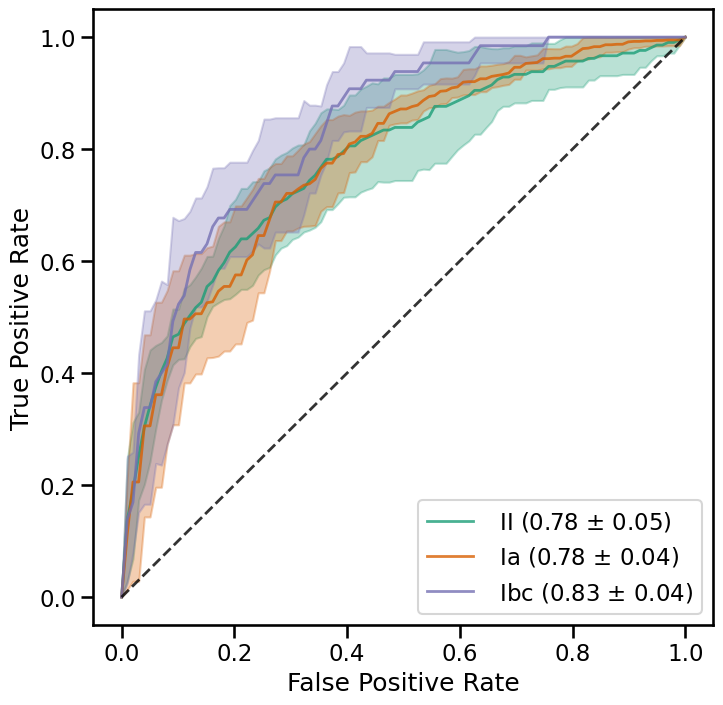

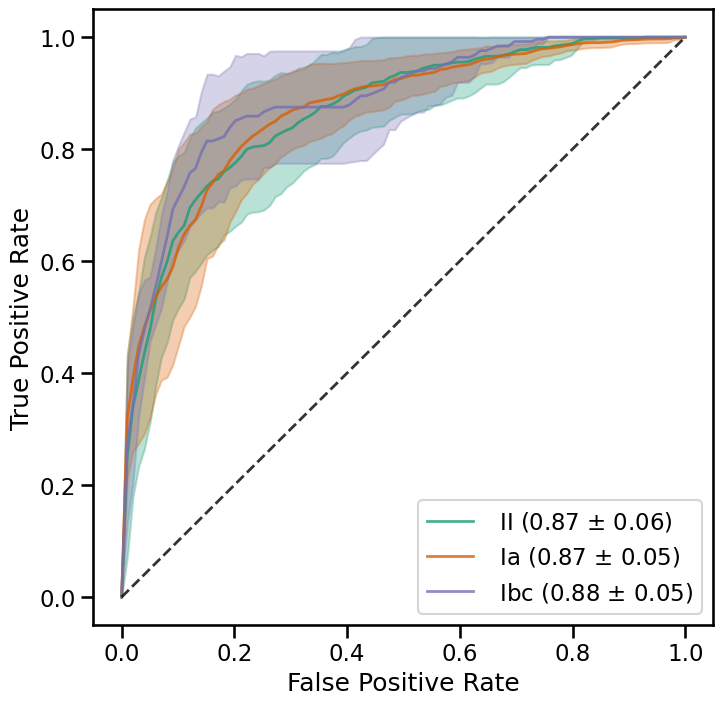

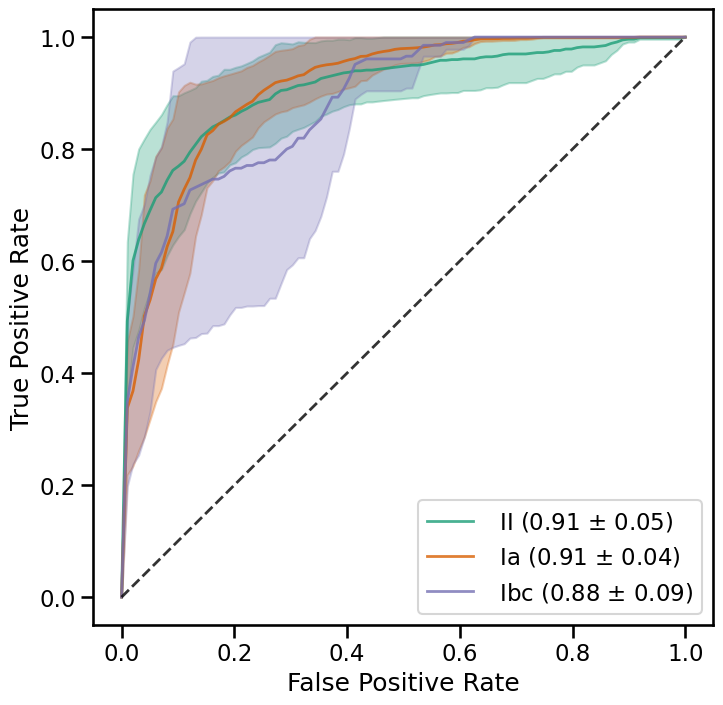

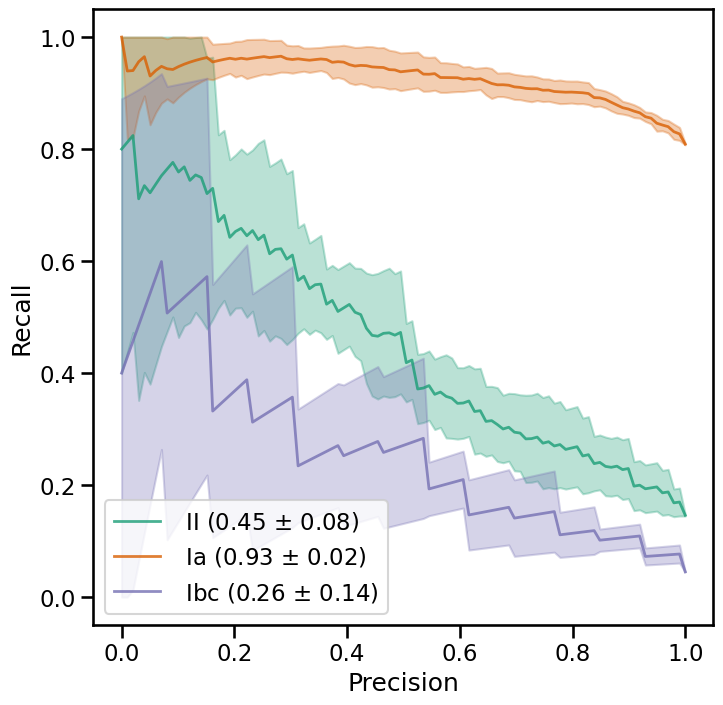

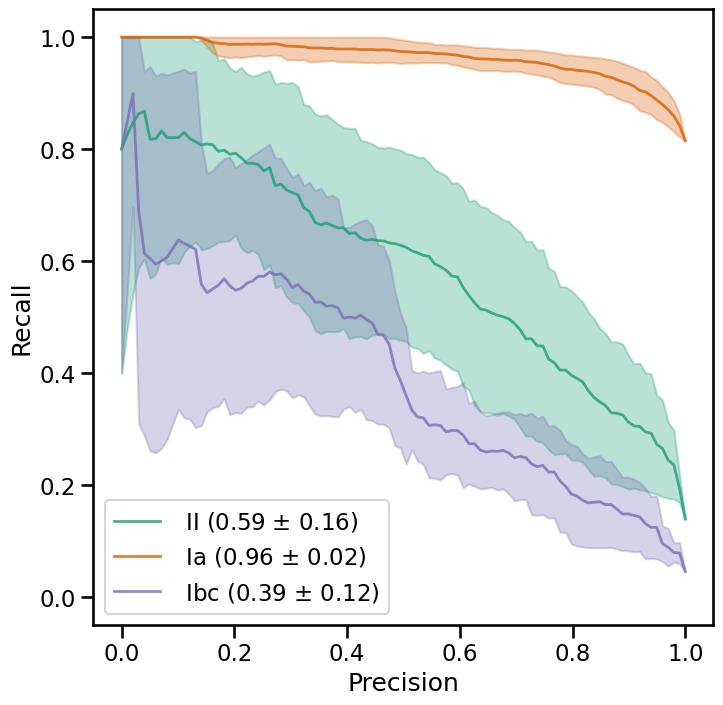

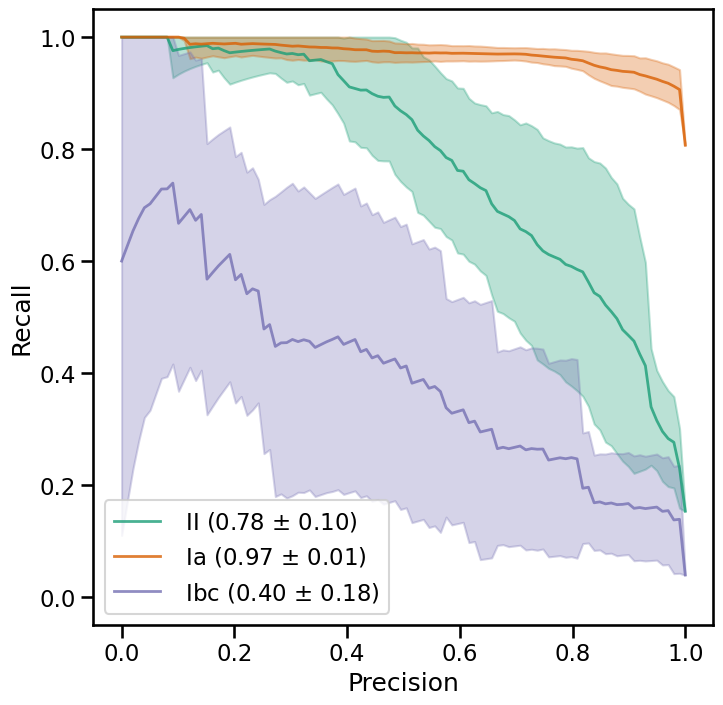

In [14]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix
from numpy import interp
sns.set_context("talk")

outdir = '/Users/alexgagliano/Documents/Research/HostClassifier/transformer/'
params = {'Nclass':3}
encoding_dict = {0:'SN II', 1:'SN Ia', 2:'SN Ibc'}

######### ROC curves ################
fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
plot_ROC_wCV(model, params, fig.gca(), X_test_first3, y_test_first3, encoding_dict, fnstr=outputfn + "_First3", plotpath=outdir+'/plots/', save=True)

fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
plot_ROC_wCV(model, params, fig.gca(), X_test_mid15, y_test_mid15, encoding_dict, fnstr=outputfn + "_Mid15", plotpath=outdir+'/plots/', save=True)

fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
plot_ROC_wCV(model, params, fig.gca(), X_test_last15, y_test_last15, encoding_dict, fnstr=outputfn + "_Last15", plotpath=outdir+'/plots/', save=True)

######### Precision-recall curves ################
fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
plot_PR_wCV(model, params, fig.gca(), X_test_first3, y_test_first3, encoding_dict, fnstr=outputfn + "_First3", plotpath=outdir+'/plots/', save=True)

fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
plot_PR_wCV(model, params, fig.gca(), X_test_mid15, y_test_mid15, encoding_dict, fnstr=outputfn + "_Mid15", plotpath=outdir+'/plots/', save=True)

fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
plot_PR_wCV(model, params, fig.gca(), X_test_last15, y_test_last15, encoding_dict, fnstr=outputfn + "_Last15", plotpath=outdir+'/plots/', save=True)